In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, DateFormatter
from sklearn.linear_model import LinearRegression

import re
import csv
import datetime as dt

%reload_ext autoreload
%autoreload 2

#### Functions

Correct optode readings for salinity and pressure

In [39]:
def Aanderaa_O2_compensation(meas_o2, temp, pres, sal, ref_sal=0):
    # Equations & coefficients from Aanderaa TD 269 Operating Manual for 4831, June 2017
    # https://www.aanderaa.com/media/pdfs/oxygen-optode-4330-4835-and-4831.pdf
    
    # Salinity
    B0 = -6.24097e-3
    B1 = -6.93498e-3
    B2 = -6.90358e-3
    B3 = -4.29155e-3
    C0 = -3.11680e-7

    ts = np.log((298.15-temp)/(273.15+temp))

    if ref_sal == 0:
        sal_corr_o2 = meas_o2 * np.exp(sal*(B0 + B1*ts + B2*ts**2 + B3*ts**3) + C0*sal**2)
    else:
        sal_corr_o2 = meas_o2 * np.exp((sal-ref_sal)*(B0 + B1*ts + B2*ts**2 + B3*ts**3) + C0*(sal**2 - ref_sal**2))

    # Apply pressure compensation to salinity-compensated values
    corr_o2 = sal_corr_o2 * (1 + (0.032*pres)/1000)

    return corr_o2


In [40]:
def PSU_to_ref_sal(psu): return psu * (35.16504/35)

Read Seabird .cnv files

In [41]:
def read_seabird(fname, pres_thresh=0.5):
    pres = []  # 0
    temps = []  # 1
    conds = []  # 2
    oxys = []  # 3
    sals = []  # 7 (absolute salinity)
    dens = []  # 8

    with open(fname, 'r') as f:
        lines = f.readlines()
        for l_i, line in enumerate(lines):
            if line[0] in ['*', '#']: continue

            line = re.sub('\s+', ',', line)[1:-1]
            vals = line.split(',')

            # Clip to min pressures
            if float(vals[0]) < pres_thresh: continue

            p = float(vals[0])
            temp = float(vals[1])
            cond = float(vals[2])
            oxy = float(vals[3])
            sal = float(vals[7])
            den = float(vals[8])

            pres.append(p)
            temps.append(temp)
            conds.append(cond)
            oxys.append(oxy)
            sals.append(sal)
            dens.append(den)

    return {
        'pres': pres,
        'temps': temps,
        'sals': sals,
        'oxys': oxys,
        'dens': dens,
        'conds': conds
    }

Read AML csv files

In [42]:
def parse_ctd_csv(cast_fpath, pres_thresh=0.5):
    datetimes = []
    pres = []
    temps = []
    sals = []
    oxys = []
    corr_oxys = []
    turbs = []
    dens = []

    cast_datestr = ''
    cast_timestr = ''
    cast_datetime = None
    date_idx = None
    time_idx = None
    pres_idx = None
    temp_idx = None
    sal_idx = None
    oxy_idx = None

    with open(cast_fpath, newline='') as f:
        reader = csv.reader(f)

        read_headings = False
        data_start = False
        for row in reader:
            if not data_start and not read_headings:
                if row[0] == '[data]':
                    # Next row will contain header
                    read_headings = True
                elif row[0].split('=')[0] == 'date':
                    cast_datestr = row[0].split('=')[1]  # yyyy-mm-dd
                elif row[0].split('=')[0] == 'time':
                    cast_timestr = row[0].split('=')[1]  # HH:MM:SS.ms
                    
            elif read_headings:
                cast_datetime_str = cast_datestr + ':' + cast_timestr[:-3]  # ignore deci-second
                cast_datetime = dt.datetime.strptime(cast_datetime_str, '%Y-%m-%d:%H:%M:%S')

                date_idx = row.index('Date (yyyy-mm-dd)')
                turb_idx = row.index('Turbidity (NTU)')
                time_idx = row.index('Time')
                pres_idx = row.index('Pressure (dBar)')
                temp_idx = row.index('Temperature (C)')
                sal_idx = row.index('Salinity (PSU)')
                oxy_idx = row.index('Aanderaa 4831')
                dens_idx = row.index('Density (kg m-3)')
                read_headings = False
                # Now expect only data rows 
                data_start = True
            
            elif data_start:
                # Merge date & time into datetime object
                sample_time = row[time_idx]
                sample_min = sample_time.split(':')[0]
                sample_sec = sample_time.split(':')[1].split('.')[0]
                sample_dsec = sample_time.split(':')[1].split('.')[1]
                sample_dt = cast_datetime.replace(
                    minute=int(sample_min),
                    second=int(sample_sec),
                    microsecond=int(sample_dsec) * int(1e5))


                # if sample_dt < sample_dt.replace(minute=52, second=45): continue
                if float(row[pres_idx]) < pres_thresh: continue

                datetimes.append(sample_dt)
                p = float(row[pres_idx])
                temp = float(row[temp_idx])
                sal = PSU_to_ref_sal(float(row[sal_idx]))
                oxy = float(row[oxy_idx])
                turb = float(row[turb_idx])
                den = float(row[dens_idx])

                pres.append(p)
                temps.append(temp)
                sals.append(sal)
                oxys.append(oxy)
                turbs.append(turb)
                dens.append(den)

                corr_o2 = Aanderaa_O2_compensation(oxy, temp, p, sal, ref_sal=0)
                corr_oxys.append(corr_o2)
                
                
    return {
        'dts': datetimes,
        'pres': pres,
        'temps': temps,
        'sals': sals,
        'oxys': oxys,
        'corr_oxys': corr_oxys,
        'dens': dens,
        'turbs': turbs
    }

Separate down- & up- casts

In [43]:
def separate_casts_seabird(down_stop_idx, up_start_idx, sb_data):
    """
    down_stop_idx & up_start_idx - sample indices
    """
    down_pres = []
    down_temps = []
    down_oxys = []
    down_corr_oxys = []
    down_sals = []
    down_dens = []

    up_pres = []
    up_temps = []
    up_oxys = []
    up_corr_oxys = []
    up_sals = []
    up_dens = []

    for i in range(len(sb_data['pres'])):
        if i < down_stop_idx:
            down_pres.append(sb_data['pres'][i])
            down_temps.append(sb_data['temps'][i])
            down_oxys.append(sb_data['oxys'][i])
            down_sals.append(sb_data['sals'][i])
            down_dens.append(sb_data['dens'][i])
        elif i > up_start_idx:
            up_pres.append(sb_data['pres'][i])
            up_temps.append(sb_data['temps'][i])
            up_oxys.append(sb_data['oxys'][i])
            up_sals.append(sb_data['sals'][i])
            up_dens.append(sb_data['dens'][i])
    
    return {
        'down': {
            'pres': down_pres,
            'temps': down_temps,
            'sals': down_sals,
            'oxys': down_oxys,
            'dens': down_dens
        },
        'up': {
            'pres': up_pres,
            'temps': up_temps,
            'sals': up_sals,
            'oxys': up_oxys,
            'dens': up_dens
        }
    }


def separate_casts_aml(down_stop_time, up_start_time, aml_data): 
    """
    down_stop_time & up_start_time - lists of [hour, minute, second]
    dts - datetime objects for each measurement
    """
    down_pres = []
    down_temps = []
    down_sals = []
    down_oxys = []
    down_corr_oxys = []
    down_dens = []

    up_pres = []
    up_temps = []
    up_sals = []
    up_oxys = []
    up_corr_oxys = []
    up_dens = []
    
    for i in range(len(aml_data['dts'])):
        if aml_data['dts'][i] < aml_data['dts'][i].replace(
                hour=down_stop_time[0],
                minute=down_stop_time[1],
                second=down_stop_time[2]):
            down_pres.append(aml_data['pres'][i])
            down_temps.append(aml_data['temps'][i])
            down_oxys.append(aml_data['oxys'][i])
            down_corr_oxys.append(aml_data['corr_oxys'][i])
            down_sals.append(aml_data['sals'][i])
            down_dens.append(aml_data['dens'][i])
    
        elif aml_data['dts'][i] > aml_data['dts'][i].replace(
                hour=up_start_time[0],
                minute=up_start_time[1],
                second=up_start_time[2]):
            up_pres.append(aml_data['pres'][i])
            up_temps.append(aml_data['temps'][i])
            up_oxys.append(aml_data['oxys'][i])
            up_corr_oxys.append(aml_data['corr_oxys'][i])
            up_sals.append(aml_data['sals'][i])
            up_dens.append(aml_data['dens'][i])

    return {
        'down': {
            'pres': down_pres,
            'temps': down_temps,
            'sals': down_sals,
            'oxys': down_oxys,
            'corr_oxys': down_corr_oxys,
            'dens': down_dens
        },
        'up': {
            'pres': up_pres,
            'temps': up_temps,
            'sals': up_sals,
            'oxys': up_oxys,
            'corr_oxys': up_corr_oxys,
            'dens': up_dens
        }
    }

Bin casts by depth

In [44]:
def bin_by_pres(pres, vals=None):
    min_pres = np.floor(min(pres))
    max_pres = np.ceil(max(pres))
    pres_bins = np.arange(min_pres, max_pres, 0.5)

    # Option to just return binned pressured values:
    if not vals: return pres_bins

    val_sums = np.zeros(pres_bins.size)
    val_counts = np.zeros(pres_bins.size)

    for i, val in enumerate(vals):
        p = pres[i]
        target_diff = p - pres_bins
        bin_idx = np.argmin(target_diff[target_diff >= 0])
        val_sums[bin_idx] = val_sums[bin_idx] + val
        val_counts[bin_idx] = val_counts[bin_idx] + 1

    binned_vals = val_sums / np.maximum(val_counts, 1)
    binned_vals[binned_vals==0] = np.nan

    return binned_vals

#### Plots

##### Cast 1 (COM2)

In [45]:
# Read seabird data
seabird_cast1_fp = 'Seabird/2023-01-14T185616 SBE0251244_filter_align_ctm_loopteos_10.cnv'
sb_cast1 = read_seabird(seabird_cast1_fp, pres_thresh=1)

# Read AML data
aml_cast1_fp = 'AML/noctiluca_saturday_cast1.csv'
aml_cast1 = parse_ctd_csv(aml_cast1_fp, pres_thresh=1)

print(f"Num. Seabird pts: {len(sb_cast1['pres'])}\nNum. AML pts: {len(aml_cast1['pres'])}")

Num. Seabird pts: 18255
Num. AML pts: 5642


Plot Pressures

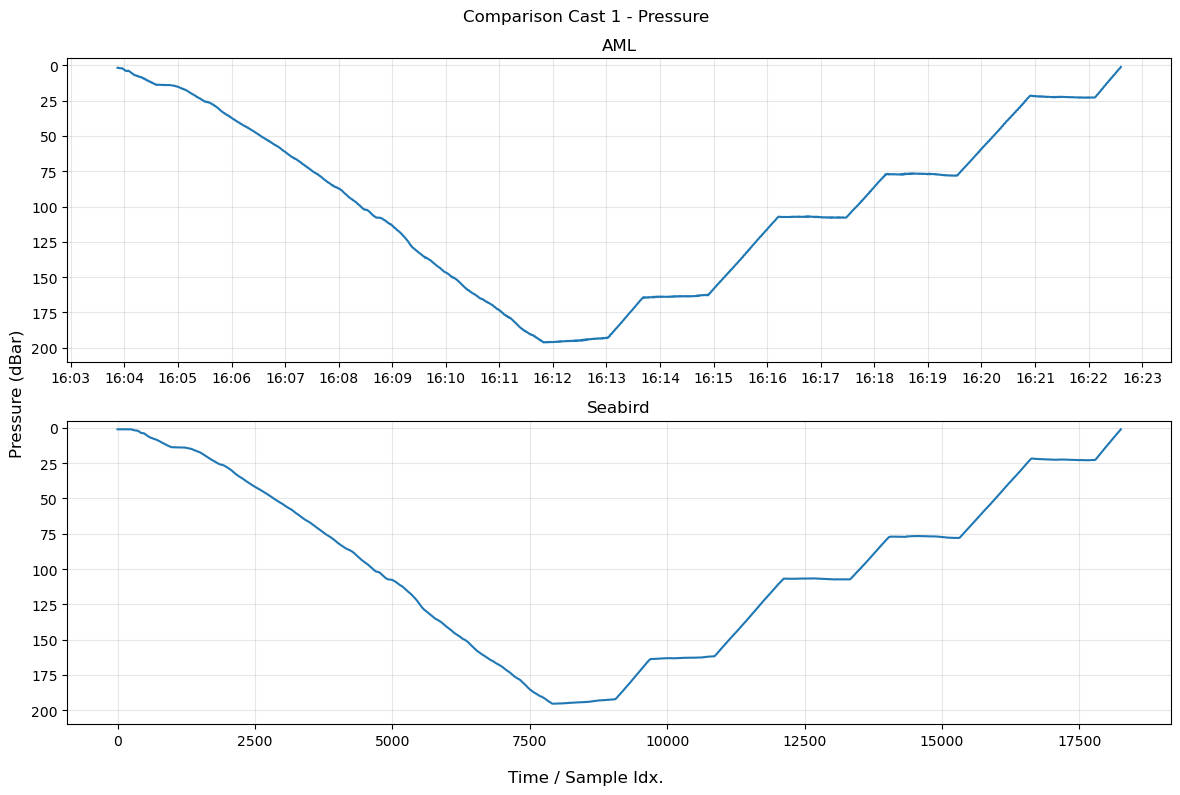

In [46]:
%matplotlib inline

fig, axs = plt.subplots(2, figsize=(12, 8))

axs[0].plot(aml_cast1['dts'], aml_cast1['pres'])
axs[0].invert_yaxis()
axs[0].grid(alpha=0.3)
mins = MinuteLocator(interval=1)
dateFmt = DateFormatter('%H:%M')
axs[0].xaxis.set_major_locator(mins)
axs[0].xaxis.set_major_formatter(dateFmt)
axs[0].set_title("AML")
axs[0].set_ylim([210, -5])

axs[1].plot(np.arange(len(sb_cast1['pres'])), sb_cast1['pres'])
axs[1].invert_yaxis()
axs[1].grid(alpha=0.3)
axs[1].set_title("Seabird")
axs[1].set_ylim([210, -5])
# axs[1].set_yticklabels([])

fig.suptitle("Comparison Cast 1 - Pressure")
fig.supxlabel('Time / Sample Idx.')
fig.supylabel("Pressure (dBar)")
# axs[0].set_ylabel("Pressure (dBar)")

# plt.savefig('figs/calib1_pres_vertical.png')
fig.tight_layout()
plt.show()

Compare values at hold depths

In [66]:
# 10s delay from start of hold depth
aml_hold180_start = [16, 13, 52]
aml_hold180_end = [16, 14, 50]
sb_hold180_start = 9900
sb_hold180_end = 10810

aml_hold120_start = [16, 16, 26]
aml_hold120_end = [16, 17, 25]
sb_hold120_start = 12335
sb_hold120_end = 13300

aml_hold80_start = [16, 18, 26]
aml_hold80_end = [16, 19, 30]
sb_hold80_start = 14273
sb_hold80_end = 15200

aml_hold25_start = [16, 21, 10]
aml_hold25_end = [16, 22, 5]
sb_hold25_start = 16860
sb_hold25_end = 17750

In [67]:
# Get AML slices
aml_hold180_pres = []
aml_hold180_temps =[]
aml_hold180_sals =[]
aml_hold180_corr_oxys = []

aml_hold120_pres = []
aml_hold120_temps =[]
aml_hold120_sals =[]
aml_hold120_corr_oxys = []

aml_hold80_pres = []
aml_hold80_temps =[]
aml_hold80_sals =[]
aml_hold80_corr_oxys = []

aml_hold25_pres = []
aml_hold25_temps =[]
aml_hold25_sals =[]
aml_hold25_corr_oxys = []

for i in range(len(aml_cast1['dts'])):
    if (aml_cast1['dts'][i] > aml_cast1['dts'][i].replace(
            hour=aml_hold180_start[0],
            minute=aml_hold180_start[1],
            second=aml_hold180_start[2])) and (aml_cast1['dts'][i] < aml_cast1['dts'][i].replace(
            hour=aml_hold180_end[0],
            minute=aml_hold180_end[1],
            second=aml_hold180_end[2])):

        aml_hold180_pres.append(aml_cast1['pres'][i])
        aml_hold180_temps.append(aml_cast1['temps'][i])
        aml_hold180_sals.append(aml_cast1['sals'][i])
        aml_hold180_corr_oxys.append(aml_cast1['corr_oxys'][i])
    
    if (aml_cast1['dts'][i] > aml_cast1['dts'][i].replace(
            hour=aml_hold120_start[0],
            minute=aml_hold120_start[1],
            second=aml_hold120_start[2])) and (aml_cast1['dts'][i] < aml_cast1['dts'][i].replace(
            hour=aml_hold120_end[0],
            minute=aml_hold120_end[1],
            second=aml_hold120_end[2])):

        aml_hold120_pres.append(aml_cast1['pres'][i])
        aml_hold120_temps.append(aml_cast1['temps'][i])
        aml_hold120_sals.append(aml_cast1['sals'][i])
        aml_hold120_corr_oxys.append(aml_cast1['corr_oxys'][i])

    if (aml_cast1['dts'][i] > aml_cast1['dts'][i].replace(
            hour=aml_hold80_start[0],
            minute=aml_hold80_start[1],
            second=aml_hold80_start[2])) and (aml_cast1['dts'][i] < aml_cast1['dts'][i].replace(
            hour=aml_hold80_end[0],
            minute=aml_hold80_end[1],
            second=aml_hold80_end[2])):

        aml_hold80_pres.append(aml_cast1['pres'][i])
        aml_hold80_temps.append(aml_cast1['temps'][i])
        aml_hold80_sals.append(aml_cast1['sals'][i])
        aml_hold80_corr_oxys.append(aml_cast1['corr_oxys'][i])

    if (aml_cast1['dts'][i] > aml_cast1['dts'][i].replace(
            hour=aml_hold25_start[0],
            minute=aml_hold25_start[1],
            second=aml_hold25_start[2])) and (aml_cast1['dts'][i] < aml_cast1['dts'][i].replace(
            hour=aml_hold25_end[0],
            minute=aml_hold25_end[1],
            second=aml_hold25_end[2])):

        aml_hold25_pres.append(aml_cast1['pres'][i])
        aml_hold25_temps.append(aml_cast1['temps'][i])
        aml_hold25_sals.append(aml_cast1['sals'][i])
        aml_hold25_corr_oxys.append(aml_cast1['corr_oxys'][i])


In [68]:
# Get Seabird slices
sb_hold180_pres = []
sb_hold180_temps =[]
sb_hold180_sals =[]
sb_hold180_oxys = []

sb_hold120_pres = []
sb_hold120_temps =[]
sb_hold120_sals =[]
sb_hold120_oxys = []

sb_hold80_pres = []
sb_hold80_temps =[]
sb_hold80_sals =[]
sb_hold80_oxys = []

sb_hold25_pres = []
sb_hold25_temps =[]
sb_hold25_sals =[]
sb_hold25_oxys = []

for i in range(len(sb_cast1['pres'])):
    if i > sb_hold180_start and i < sb_hold180_end:
        sb_hold180_pres.append(sb_cast1['pres'][i])
        sb_hold180_temps.append(sb_cast1['temps'][i])
        sb_hold180_oxys.append(sb_cast1['oxys'][i])
        sb_hold180_sals.append(sb_cast1['sals'][i])
    
    if i > sb_hold120_start and i < sb_hold120_end:
        sb_hold120_pres.append(sb_cast1['pres'][i])
        sb_hold120_temps.append(sb_cast1['temps'][i])
        sb_hold120_oxys.append(sb_cast1['oxys'][i])
        sb_hold120_sals.append(sb_cast1['sals'][i])

    if i > sb_hold80_start and i < sb_hold80_end:
        sb_hold80_pres.append(sb_cast1['pres'][i])
        sb_hold80_temps.append(sb_cast1['temps'][i])
        sb_hold80_oxys.append(sb_cast1['oxys'][i])
        sb_hold80_sals.append(sb_cast1['sals'][i])
    
    if i > sb_hold25_start and i < sb_hold25_end:
        sb_hold25_pres.append(sb_cast1['pres'][i])
        sb_hold25_temps.append(sb_cast1['temps'][i])
        sb_hold25_oxys.append(sb_cast1['oxys'][i])
        sb_hold25_sals.append(sb_cast1['sals'][i])

In [70]:
# Bin 'em
aml_hold180_pres_binned = bin_by_pres(aml_hold180_pres)
aml_hold180_temps_binned = bin_by_pres(aml_hold180_pres, aml_hold180_temps)
aml_hold180_sals_binned = bin_by_pres(aml_hold180_pres, aml_hold180_sals)
aml_hold180_oxys_binned = bin_by_pres(aml_hold180_pres, aml_hold180_corr_oxys)

aml_hold120_pres_binned = bin_by_pres(aml_hold120_pres)
aml_hold120_temps_binned = bin_by_pres(aml_hold120_pres, aml_hold120_temps)
aml_hold120_sals_binned = bin_by_pres(aml_hold120_pres, aml_hold120_sals)
aml_hold120_corr_oxys_binned = bin_by_pres(aml_hold120_pres, aml_hold120_corr_oxys)

aml_hold80_pres_binned = bin_by_pres(aml_hold80_pres)
aml_hold80_temps_binned = bin_by_pres(aml_hold80_pres, aml_hold80_temps)
aml_hold80_sals_binned = bin_by_pres(aml_hold80_pres, aml_hold80_sals)
aml_hold80_corr_oxys_binned = bin_by_pres(aml_hold80_pres, aml_hold80_corr_oxys)

aml_hold25_pres_binned = bin_by_pres(aml_hold25_pres)
aml_hold25_temps_binned = bin_by_pres(aml_hold25_pres, aml_hold25_temps)
aml_hold25_sals_binned = bin_by_pres(aml_hold25_pres, aml_hold25_sals)
aml_hold25_corr_oxys_binned = bin_by_pres(aml_hold25_pres, aml_hold25_corr_oxys)


sb_hold180_pres_binned = bin_by_pres(sb_hold180_pres)
sb_hold180_temps_binned = bin_by_pres(sb_hold180_pres, sb_hold180_temps)
sb_hold180_sals_binned = bin_by_pres(sb_hold180_pres, sb_hold180_sals)
sb_hold180_oxys_binned = bin_by_pres(sb_hold180_pres, sb_hold180_oxys)

sb_hold120_pres_binned = bin_by_pres(sb_hold120_pres)
sb_hold120_temps_binned = bin_by_pres(sb_hold120_pres, sb_hold120_temps)
sb_hold120_sals_binned = bin_by_pres(sb_hold120_pres, sb_hold120_sals)
sb_hold120_oxys_binned = bin_by_pres(sb_hold120_pres, sb_hold120_oxys)

sb_hold80_pres_binned = bin_by_pres(sb_hold80_pres)
sb_hold80_temps_binned = bin_by_pres(sb_hold80_pres, sb_hold80_temps)
sb_hold80_sals_binned = bin_by_pres(sb_hold80_pres, sb_hold80_sals)
sb_hold80_oxys_binned = bin_by_pres(sb_hold80_pres, sb_hold80_oxys)

sb_hold25_pres_binned = bin_by_pres(sb_hold25_pres)
sb_hold25_temps_binned = bin_by_pres(sb_hold25_pres, sb_hold25_temps)
sb_hold25_sals_binned = bin_by_pres(sb_hold25_pres, sb_hold25_sals)
sb_hold25_oxys_binned = bin_by_pres(sb_hold25_pres, sb_hold25_oxys)

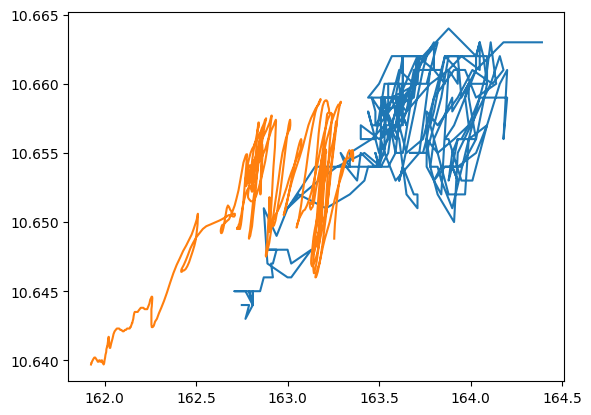

In [75]:
plt.plot(aml_hold180_pres, aml_hold180_temps)
plt.plot(sb_hold180_pres, sb_hold180_temps)

plt.show()

Separate & Bin Casts

In [47]:
sb_down1_stop_idx = 8000
sb_up1_start_idx = 8750

aml_down1_stop_time = [16,12,0]  # H, M, S
aml_up1_start_time = [16,12,30]

sb_casts1 = separate_casts_seabird(sb_down1_stop_idx, sb_up1_start_idx, sb_cast1)
aml_casts1 = separate_casts_aml(aml_down1_stop_time, aml_up1_start_time, aml_cast1)

# Seabird down
sb_down1_pres_binned = bin_by_pres(sb_casts1['down']['pres'])
sb_down1_temps_binned = bin_by_pres(sb_casts1['down']['pres'], sb_casts1['down']['temps'])
sb_down1_sals_binned = bin_by_pres(sb_casts1['down']['pres'], sb_casts1['down']['sals'])
sb_down1_oxys_binned = bin_by_pres(sb_casts1['down']['pres'], sb_casts1['down']['oxys'])
sb_down1_dens_binned = bin_by_pres(sb_casts1['down']['pres'], sb_casts1['down']['dens'])

# AML down
aml_down1_pres_binned = bin_by_pres(aml_casts1['down']['pres'])
aml_down1_temps_binned = bin_by_pres(aml_casts1['down']['pres'], aml_casts1['down']['temps'])
aml_down1_sals_binned = bin_by_pres(aml_casts1['down']['pres'], aml_casts1['down']['sals'])
aml_down1_oxys_binned = bin_by_pres(aml_casts1['down']['pres'], aml_casts1['down']['oxys'])
aml_down1_corr_oxys_binned = bin_by_pres(aml_casts1['down']['pres'], aml_casts1['down']['corr_oxys'])
aml_down1_dens_binned = bin_by_pres(aml_casts1['down']['pres'], aml_casts1['down']['dens'])

Plot Profiles

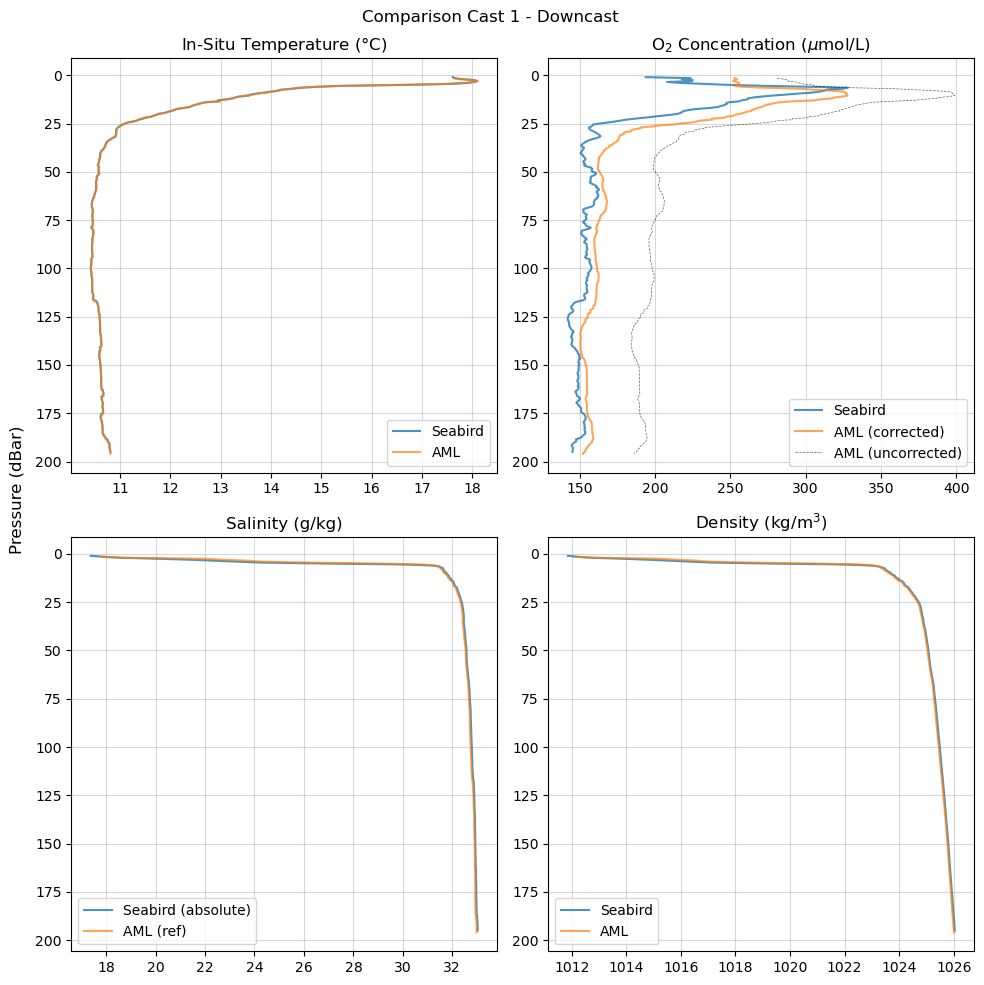

In [48]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0, 0].plot(sb_down1_temps_binned, sb_down1_pres_binned, label='Seabird', alpha=0.8)
axs[0, 0].plot(aml_down1_temps_binned, aml_down1_pres_binned, label='AML', alpha=0.7)
axs[0, 0].legend(loc=4)
axs[0, 0].invert_yaxis()
axs[0, 0].grid(alpha=0.5)
axs[0, 0].set_title("In-Situ Temperature ($\degree$C)")

axs[0, 1].plot(sb_down1_oxys_binned, sb_down1_pres_binned, label='Seabird', alpha=0.8)
axs[0, 1].plot(aml_down1_corr_oxys_binned, aml_down1_pres_binned, label='AML (corrected)', alpha=0.7)
axs[0, 1].plot(aml_down1_oxys_binned, aml_down1_pres_binned, 'k--', label='AML (uncorrected)', alpha=0.6, linewidth=0.5)
axs[0, 1].legend(loc=4)
axs[0, 1].invert_yaxis()
axs[0, 1].grid(alpha=0.5)
axs[0, 1].set_title("O$_2$ Concentration ($\mu$mol/L)")

axs[1, 0].plot(sb_down1_sals_binned, sb_down1_pres_binned, label='Seabird (absolute)', alpha=0.8)
axs[1, 0].plot(aml_down1_sals_binned, aml_down1_pres_binned, label='AML (ref)', alpha=0.7)
axs[1, 0].legend(loc=3)
axs[1, 0].invert_yaxis()
axs[1, 0].grid(alpha=0.5)
axs[1, 0].set_title("Salinity (g/kg)")

axs[1, 1].plot(sb_down1_dens_binned, sb_down1_pres_binned, label='Seabird', alpha=0.8)
axs[1, 1].plot(aml_down1_dens_binned, aml_down1_pres_binned, label='AML', alpha=0.7)
axs[1, 1].legend(loc=3)
axs[1, 1].invert_yaxis()
axs[1, 1].grid(alpha=0.5)
axs[1, 1].set_title("Density (kg/m$^3$)")

fig.suptitle("Comparison Cast 1 - Downcast")
fig.supylabel("Pressure (dBar)")
fig.tight_layout()

plt.savefig('figs/calib1_downcast.png')
plt.show()

##### Cast 2 (middle)

In [49]:
# Read seabird data
seabird_cast2_fp = 'Seabird/2023-01-14T193745 SBE0251244_filter_align_ctm_loopteos_10.cnv'
sb_cast2 = read_seabird(seabird_cast2_fp, pres_thresh=1)

# Read AML data
aml_cast2_fp = 'AML/noctiluca_saturday_cast2.csv'
aml_cast2 = parse_ctd_csv(aml_cast2_fp, pres_thresh=1)

print(f"Num. Seabird pts: {len(sb_cast2['pres'])}\nNum. AML pts: {len(aml_cast2['pres'])}")

Num. Seabird pts: 3872
Num. AML pts: 1211


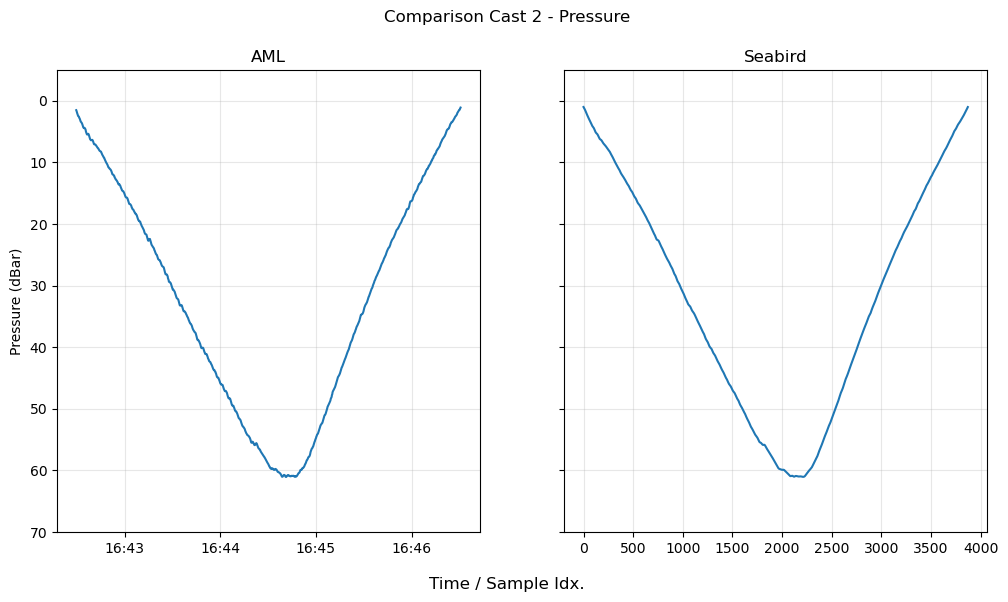

In [50]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(aml_cast2['dts'], aml_cast2['pres'])
axs[0].invert_yaxis()
axs[0].grid(alpha=0.3)
mins = MinuteLocator(interval=1)
dateFmt = DateFormatter('%H:%M')
axs[0].xaxis.set_major_locator(mins)
axs[0].xaxis.set_major_formatter(dateFmt)
axs[0].set_title("AML")
axs[0].set_ylim([70, -5])

axs[1].plot(np.arange(len(sb_cast2['pres'])), sb_cast2['pres'])
axs[1].invert_yaxis()
axs[1].grid(alpha=0.3)
axs[1].set_title("Seabird")
axs[1].set_ylim([70, -5])
axs[1].set_yticklabels([])

fig.suptitle("Comparison Cast 2 - Pressure")
fig.supxlabel('Time / Sample Idx.')
axs[0].set_ylabel("Pressure (dBar)")

# plt.savefig('figs/calib2_pres.png')
plt.show()

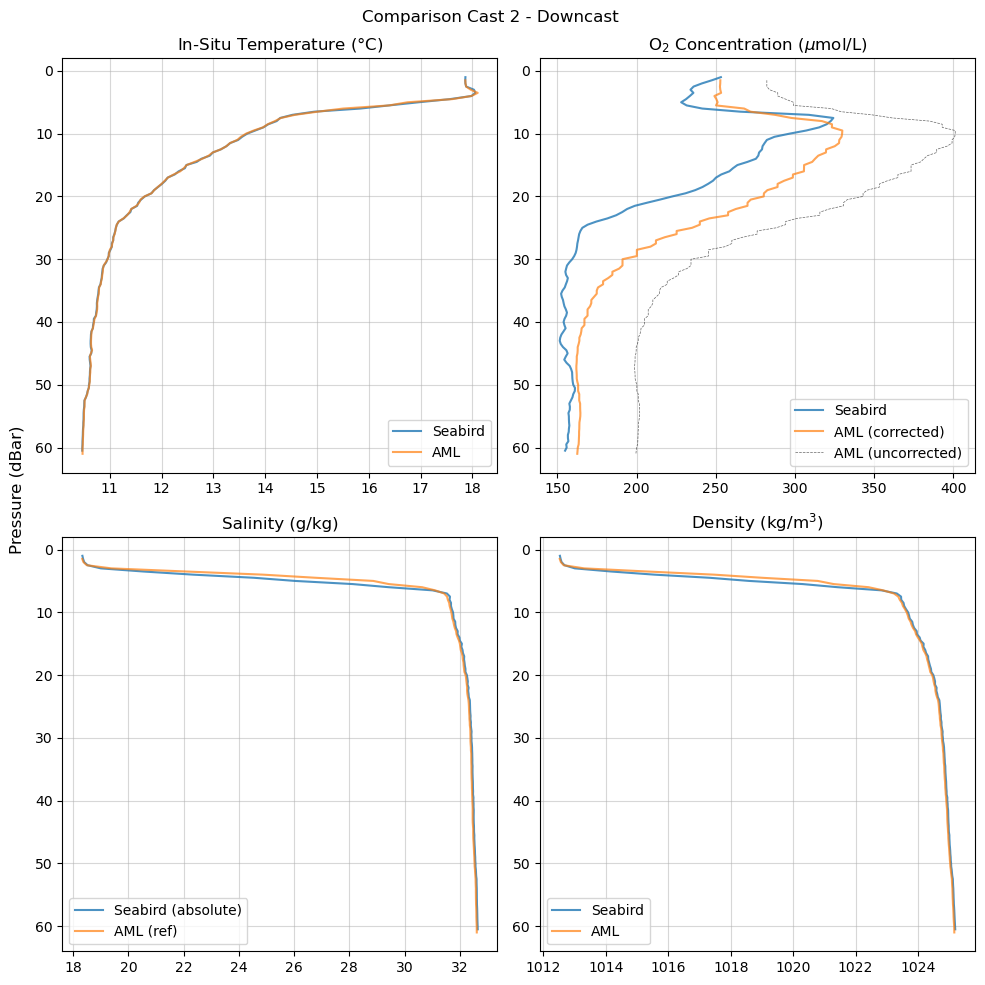

In [51]:
sb_down2_stop_idx = 2100
sb_up2_start_idx = 2200

aml_down2_stop_time = [16,44,40]  # H, M, S
aml_up2_start_time = [16,44,40]

sb_casts2 = separate_casts_seabird(sb_down2_stop_idx, sb_up2_start_idx, sb_cast2)
aml_casts2 = separate_casts_aml(aml_down2_stop_time, aml_up2_start_time, aml_cast2)

# Seabird down
sb_down2_pres_binned = bin_by_pres(sb_casts2['down']['pres'])
sb_down2_temps_binned = bin_by_pres(sb_casts2['down']['pres'], sb_casts2['down']['temps'])
sb_down2_sals_binned = bin_by_pres(sb_casts2['down']['pres'], sb_casts2['down']['sals'])
sb_down2_oxys_binned = bin_by_pres(sb_casts2['down']['pres'], sb_casts2['down']['oxys'])
sb_down2_dens_binned = bin_by_pres(sb_casts2['down']['pres'], sb_casts2['down']['dens'])

# AML down
aml_down2_pres_binned = bin_by_pres(aml_casts2['down']['pres'])
aml_down2_temps_binned = bin_by_pres(aml_casts2['down']['pres'], aml_casts2['down']['temps'])
aml_down2_sals_binned = bin_by_pres(aml_casts2['down']['pres'], aml_casts2['down']['sals'])
aml_down2_oxys_binned = bin_by_pres(aml_casts2['down']['pres'], aml_casts2['down']['oxys'])
aml_down2_corr_oxys_binned = bin_by_pres(aml_casts2['down']['pres'], aml_casts2['down']['corr_oxys'])
aml_down2_dens_binned = bin_by_pres(aml_casts2['down']['pres'], aml_casts2['down']['dens'])


fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0, 0].plot(sb_down2_temps_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[0, 0].plot(aml_down2_temps_binned, aml_down2_pres_binned, label='AML', alpha=0.7)
axs[0, 0].legend(loc=4)
axs[0, 0].invert_yaxis()
axs[0, 0].grid(alpha=0.5)
axs[0, 0].set_title("In-Situ Temperature ($\degree$C)")

axs[0, 1].plot(sb_down2_oxys_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[0, 1].plot(aml_down2_corr_oxys_binned, aml_down2_pres_binned, label='AML (corrected)', alpha=0.7)
axs[0, 1].plot(aml_down2_oxys_binned, aml_down2_pres_binned, 'k--', label='AML (uncorrected)', alpha=0.6, linewidth=0.5)
axs[0, 1].legend(loc=4)
axs[0, 1].invert_yaxis()
axs[0, 1].grid(alpha=0.5)
axs[0, 1].set_title("O$_2$ Concentration ($\mu$mol/L)")

axs[1, 0].plot(sb_down2_sals_binned, sb_down2_pres_binned, label='Seabird (absolute)', alpha=0.8)
axs[1, 0].plot(aml_down2_sals_binned, aml_down2_pres_binned, label='AML (ref)', alpha=0.7)
axs[1, 0].legend(loc=3)
axs[1, 0].invert_yaxis()
axs[1, 0].grid(alpha=0.5)
axs[1, 0].set_title("Salinity (g/kg)")

axs[1, 1].plot(sb_down2_dens_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[1, 1].plot(aml_down2_dens_binned, aml_down2_pres_binned, label='AML', alpha=0.7)
axs[1, 1].legend(loc=3)
axs[1, 1].invert_yaxis()
axs[1, 1].grid(alpha=0.5)
axs[1, 1].set_title("Density (kg/m$^3$)")

fig.suptitle("Comparison Cast 2 - Downcast")
fig.supylabel("Pressure (dBar)")
fig.tight_layout()

plt.savefig('figs/calib2_downcast.png')
plt.show()

##### Cast 3 (Head)

In [52]:
# Read seabird data
seabird_cast3_fp = 'Seabird/2023-01-14T200724 SBE0251244_filter_align_ctm_loopteos_10.cnv'
sb_cast3 = read_seabird(seabird_cast3_fp, pres_thresh=1.5)

# Read AML data
aml_cast3_fp = 'AML/noctiluca_saturday_cast3.csv'
aml_cast3 = parse_ctd_csv(aml_cast3_fp, pres_thresh=1.5)

print(f"Num. Seabird pts: {len(sb_cast3['pres'])}\nNum. AML pts: {len(aml_cast3['pres'])}")

Num. Seabird pts: 3759
Num. AML pts: 1180


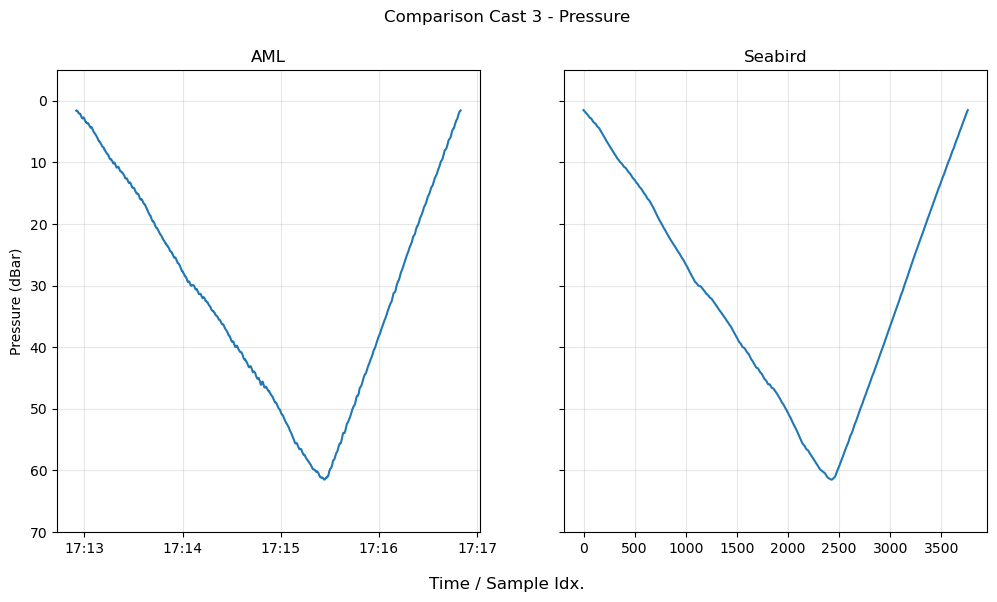

In [53]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(aml_cast3['dts'], aml_cast3['pres'])
axs[0].invert_yaxis()
axs[0].grid(alpha=0.3)
mins = MinuteLocator(interval=1)
dateFmt = DateFormatter('%H:%M')
axs[0].xaxis.set_major_locator(mins)
axs[0].xaxis.set_major_formatter(dateFmt)
axs[0].set_title("AML")
axs[0].set_ylim([70, -5])

axs[1].plot(np.arange(len(sb_cast3['pres'])), sb_cast3['pres'])
axs[1].invert_yaxis()
axs[1].grid(alpha=0.3)
axs[1].set_title("Seabird")
axs[1].set_ylim([70, -5])
axs[1].set_yticklabels([])

fig.suptitle("Comparison Cast 3 - Pressure")
fig.supxlabel('Time / Sample Idx.')
axs[0].set_ylabel("Pressure (dBar)")

# plt.savefig('figs/calib3_pres.png')
plt.show()

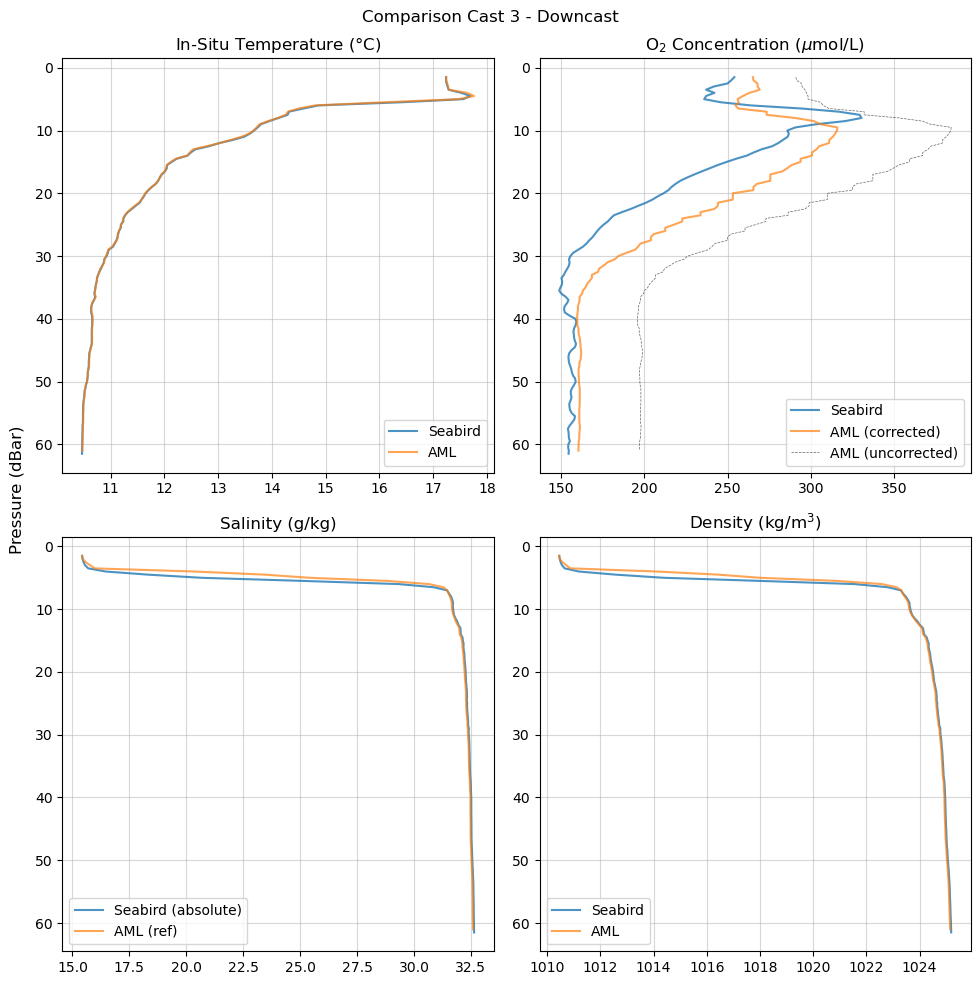

In [54]:
sb_down3_stop_idx = 2450
sb_up3_start_idx = 2450

aml_down3_stop_time = [17,15,25]  # H, M, S
aml_up3_start_time = [17,15,26]

sb_casts3 = separate_casts_seabird(sb_down3_stop_idx, sb_up3_start_idx, sb_cast3)
aml_casts3 = separate_casts_aml(aml_down3_stop_time, aml_up3_start_time, aml_cast3)

# Seabird down
sb_down3_pres_binned = bin_by_pres(sb_casts3['down']['pres'])
sb_down3_temps_binned = bin_by_pres(sb_casts3['down']['pres'], sb_casts3['down']['temps'])
sb_down3_sals_binned = bin_by_pres(sb_casts3['down']['pres'], sb_casts3['down']['sals'])
sb_down3_oxys_binned = bin_by_pres(sb_casts3['down']['pres'], sb_casts3['down']['oxys'])
sb_down3_dens_binned = bin_by_pres(sb_casts3['down']['pres'], sb_casts3['down']['dens'])

# AML down
aml_down3_pres_binned = bin_by_pres(aml_casts3['down']['pres'])
aml_down3_temps_binned = bin_by_pres(aml_casts3['down']['pres'], aml_casts3['down']['temps'])
aml_down3_sals_binned = bin_by_pres(aml_casts3['down']['pres'], aml_casts3['down']['sals'])
aml_down3_oxys_binned = bin_by_pres(aml_casts3['down']['pres'], aml_casts3['down']['oxys'])
aml_down3_corr_oxys_binned = bin_by_pres(aml_casts3['down']['pres'], aml_casts3['down']['corr_oxys'])
aml_down3_dens_binned = bin_by_pres(aml_casts3['down']['pres'], aml_casts3['down']['dens'])


fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0, 0].plot(sb_down3_temps_binned, sb_down3_pres_binned, label='Seabird', alpha=0.8)
axs[0, 0].plot(aml_down3_temps_binned, aml_down3_pres_binned, label='AML', alpha=0.7)
axs[0, 0].legend(loc=4)
axs[0, 0].invert_yaxis()
axs[0, 0].grid(alpha=0.5)
axs[0, 0].set_title("In-Situ Temperature ($\degree$C)")

axs[0, 1].plot(sb_down3_oxys_binned, sb_down3_pres_binned, label='Seabird', alpha=0.8)
axs[0, 1].plot(aml_down3_corr_oxys_binned, aml_down3_pres_binned, label='AML (corrected)', alpha=0.7)
axs[0, 1].plot(aml_down3_oxys_binned, aml_down3_pres_binned, 'k--', label='AML (uncorrected)', alpha=0.6, linewidth=0.5)
axs[0, 1].legend(loc=4)
axs[0, 1].invert_yaxis()
axs[0, 1].grid(alpha=0.5)
axs[0, 1].set_title("O$_2$ Concentration ($\mu$mol/L)")

axs[1, 0].plot(sb_down3_sals_binned, sb_down3_pres_binned, label='Seabird (absolute)', alpha=0.8)
axs[1, 0].plot(aml_down3_sals_binned, aml_down3_pres_binned, label='AML (ref)', alpha=0.7)
axs[1, 0].legend(loc=3)
axs[1, 0].invert_yaxis()
axs[1, 0].grid(alpha=0.5)
axs[1, 0].set_title("Salinity (g/kg)")

axs[1, 1].plot(sb_down3_dens_binned, sb_down3_pres_binned, label='Seabird', alpha=0.8)
axs[1, 1].plot(aml_down3_dens_binned, aml_down3_pres_binned, label='AML', alpha=0.7)
axs[1, 1].legend(loc=3)
axs[1, 1].invert_yaxis()
axs[1, 1].grid(alpha=0.5)
axs[1, 1].set_title("Density (kg/m$^3$)")

fig.suptitle("Comparison Cast 3 - Downcast")
fig.supylabel("Pressure (dBar)")
fig.tight_layout()

plt.savefig('figs/calib3_downcast.png')
plt.show()

##### All casts

Down

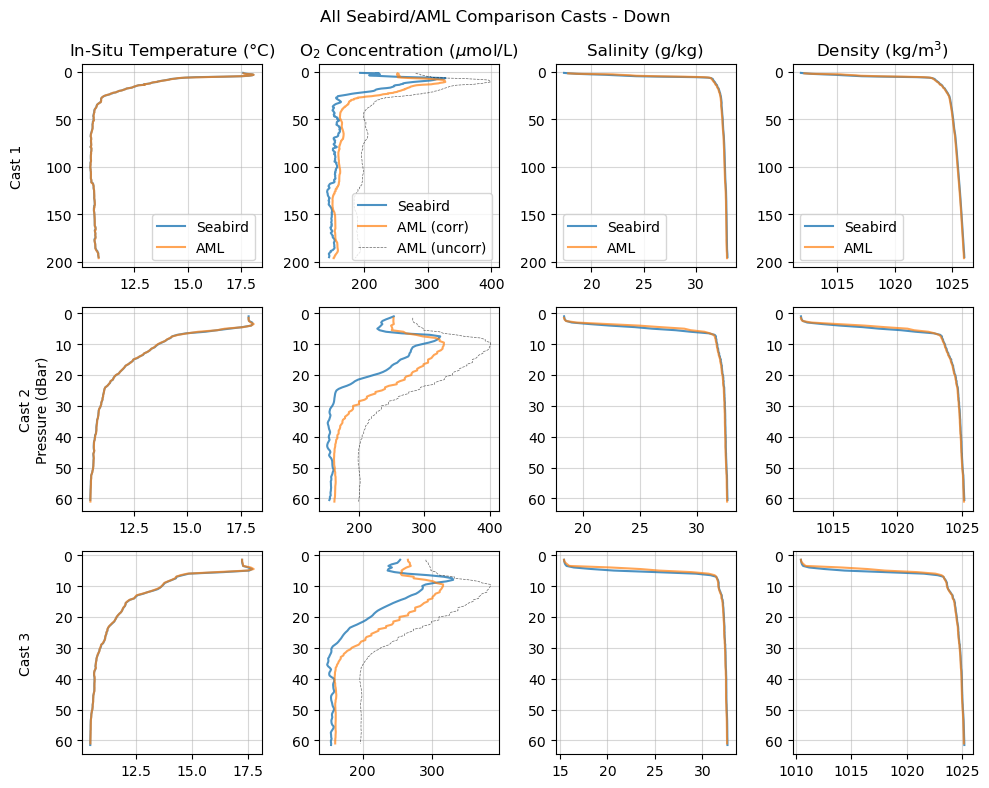

In [55]:
fig, axs = plt.subplots(3, 4, figsize=(10, 8))

# Temp
axs[0, 0].plot(sb_down1_temps_binned, sb_down1_pres_binned, label='Seabird', alpha=0.8)
axs[0, 0].plot(aml_down1_temps_binned, aml_down1_pres_binned, label='AML', alpha=0.7)
axs[0, 0].legend()
axs[0, 0].invert_yaxis()
axs[0, 0].grid(alpha=0.5)
axs[0, 0].set_ylabel("Cast 1\n")

axs[1, 0].plot(sb_down2_temps_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[1, 0].plot(aml_down2_temps_binned, aml_down2_pres_binned, label='AML', alpha=0.7)
# axs[1, 0].legend(loc=4)
axs[1, 0].invert_yaxis()
axs[1, 0].grid(alpha=0.5)
axs[1, 0].set_ylabel("Cast 2\nPressure (dBar)")
axs[0, 0].set_title("In-Situ Temperature ($\degree$C)")

axs[2, 0].plot(sb_down3_temps_binned, sb_down3_pres_binned, label='Seabird', alpha=0.8)
axs[2, 0].plot(aml_down3_temps_binned, aml_down3_pres_binned, label='AML', alpha=0.7)
axs[2, 0].invert_yaxis()
axs[2, 0].grid(alpha=0.5)
axs[2, 0].set_ylabel("Cast 3\n")

# Oxygen
axs[0,1].plot(sb_down1_oxys_binned, sb_down1_pres_binned, label='Seabird', alpha=0.8)
axs[0,1].plot(aml_down1_corr_oxys_binned, aml_down1_pres_binned, label='AML (corr)', alpha=0.7)
axs[0,1].plot(aml_down1_oxys_binned, aml_down1_pres_binned, 'k--', label='AML (uncorr)', alpha=0.6, linewidth=0.5)
axs[0,1].legend()
axs[0,1].invert_yaxis()
axs[0,1].grid(alpha=0.5)

axs[1, 1].plot(sb_down2_oxys_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[1, 1].plot(aml_down2_corr_oxys_binned, aml_down2_pres_binned, label='AML (corr)', alpha=0.7)
axs[1, 1].plot(aml_down2_oxys_binned, aml_down2_pres_binned, 'k--', label='AML (uncorr)', alpha=0.6, linewidth=0.5)
# axs[1, 1].legend(loc=4)
axs[1, 1].invert_yaxis()
axs[1, 1].grid(alpha=0.5)
axs[0, 1].set_title("O$_2$ Concentration ($\mu$mol/L)")

axs[2, 1].plot(sb_down3_oxys_binned, sb_down3_pres_binned, label='Seabird', alpha=0.8)
axs[2, 1].plot(aml_down3_corr_oxys_binned, aml_down3_pres_binned, label='AML (corr)', alpha=0.7)
axs[2, 1].plot(aml_down3_oxys_binned, aml_down3_pres_binned, 'k--', label='AML (uncorr)', alpha=0.6, linewidth=0.5)
axs[2, 1].invert_yaxis()
axs[2, 1].grid(alpha=0.5)

# Salinity
axs[0,2].plot(sb_down1_sals_binned, sb_down1_pres_binned, label='Seabird', alpha=0.8)
axs[0,2].plot(aml_down1_sals_binned, aml_down1_pres_binned, label='AML', alpha=0.7)
axs[0,2].legend()
axs[0,2].invert_yaxis()
axs[0,2].grid(alpha=0.5)

axs[1,2].plot(sb_down2_sals_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[1,2].plot(aml_down2_sals_binned, aml_down2_pres_binned, label='AML', alpha=0.7)
# axs[1,2].legend(loc=3)
axs[1,2].invert_yaxis()
axs[1,2].grid(alpha=0.5)
axs[0,2].set_title("Salinity (g/kg)")

axs[2, 2].plot(sb_down3_sals_binned, sb_down3_pres_binned, label='Seabird', alpha=0.8)
axs[2, 2].plot(aml_down3_sals_binned, aml_down3_pres_binned, label='AML', alpha=0.7)
axs[2, 2].invert_yaxis()
axs[2, 2].grid(alpha=0.5)

# Density
axs[0, 3].plot(sb_down1_dens_binned, sb_down1_pres_binned, label='Seabird', alpha=0.8)
axs[0, 3].plot(aml_down1_dens_binned, aml_down1_pres_binned, label='AML', alpha=0.7)
axs[0,3].legend()
axs[0, 3].invert_yaxis()
axs[0, 3].grid(alpha=0.5)

axs[1,3].plot(sb_down2_dens_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[1,3].plot(aml_down2_dens_binned, aml_down2_pres_binned, label='AML', alpha=0.7)
# axs[1,3].legend(loc=3)
axs[1,3].invert_yaxis()
axs[1,3].grid(alpha=0.5)
axs[1,3].locator_params(axis='x', nbins=3)
axs[0,3].set_title("Density (kg/m$^3$)")

axs[2,3].plot(sb_down3_dens_binned, sb_down3_pres_binned, label='Seabird', alpha=0.8)
axs[2,3].plot(aml_down3_dens_binned, aml_down3_pres_binned, label='AML', alpha=0.7)
axs[2,3].invert_yaxis()
axs[2,3].grid(alpha=0.5)
# axs[3, 2].locator_params(axis='x', nbins=3)

plt.suptitle("All Seabird/AML Comparison Casts - Down")
fig.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('figs/all_calibs_downcast_compressed.png')
fig.tight_layout()
plt.show()


Up

In [56]:
# Cast 3
sb_up1_pres_binned = bin_by_pres(sb_casts1['up']['pres'])
sb_up1_temps_binned = bin_by_pres(sb_casts1['up']['pres'], sb_casts1['up']['temps'])
sb_up1_sals_binned = bin_by_pres(sb_casts1['up']['pres'], sb_casts1['up']['sals'])
sb_up1_oxys_binned = bin_by_pres(sb_casts1['up']['pres'], sb_casts1['up']['oxys'])
sb_up1_dens_binned = bin_by_pres(sb_casts1['up']['pres'], sb_casts1['up']['dens'])

aml_up1_pres_binned = bin_by_pres(aml_casts1['up']['pres'])
aml_up1_temps_binned = bin_by_pres(aml_casts1['up']['pres'], aml_casts1['up']['temps'])
aml_up1_sals_binned = bin_by_pres(aml_casts1['up']['pres'], aml_casts1['up']['sals'])
aml_up1_oxys_binned = bin_by_pres(aml_casts1['up']['pres'], aml_casts1['up']['oxys'])
aml_up1_dens_binned = bin_by_pres(aml_casts1['up']['pres'], aml_casts1['up']['dens'])

# Cast 2
sb_up2_pres_binned = bin_by_pres(sb_casts2['up']['pres'])
sb_up2_temps_binned = bin_by_pres(sb_casts2['up']['pres'], sb_casts2['up']['temps'])
sb_up2_sals_binned = bin_by_pres(sb_casts2['up']['pres'], sb_casts2['up']['sals'])
sb_up2_oxys_binned = bin_by_pres(sb_casts2['up']['pres'], sb_casts2['up']['oxys'])
sb_up2_dens_binned = bin_by_pres(sb_casts2['up']['pres'], sb_casts2['up']['dens'])

aml_up2_pres_binned = bin_by_pres(aml_casts2['up']['pres'])
aml_up2_temps_binned = bin_by_pres(aml_casts2['up']['pres'], aml_casts2['up']['temps'])
aml_up2_sals_binned = bin_by_pres(aml_casts2['up']['pres'], aml_casts2['up']['sals'])
aml_up2_oxys_binned = bin_by_pres(aml_casts2['up']['pres'], aml_casts2['up']['oxys'])
aml_up2_dens_binned = bin_by_pres(aml_casts2['up']['pres'], aml_casts2['up']['dens'])

# Cast 3
sb_up3_pres_binned = bin_by_pres(sb_casts3['up']['pres'])
sb_up3_temps_binned = bin_by_pres(sb_casts3['up']['pres'], sb_casts3['up']['temps'])
sb_up3_sals_binned = bin_by_pres(sb_casts3['up']['pres'], sb_casts3['up']['sals'])
sb_up3_oxys_binned = bin_by_pres(sb_casts3['up']['pres'], sb_casts3['up']['oxys'])
sb_up3_dens_binned = bin_by_pres(sb_casts3['up']['pres'], sb_casts3['up']['dens'])

aml_up3_pres_binned = bin_by_pres(aml_casts3['up']['pres'])
aml_up3_temps_binned = bin_by_pres(aml_casts3['up']['pres'], aml_casts3['up']['temps'])
aml_up3_sals_binned = bin_by_pres(aml_casts3['up']['pres'], aml_casts3['up']['sals'])
aml_up3_oxys_binned = bin_by_pres(aml_casts3['up']['pres'], aml_casts3['up']['oxys'])
aml_up3_dens_binned = bin_by_pres(aml_casts3['up']['pres'], aml_casts3['up']['dens'])

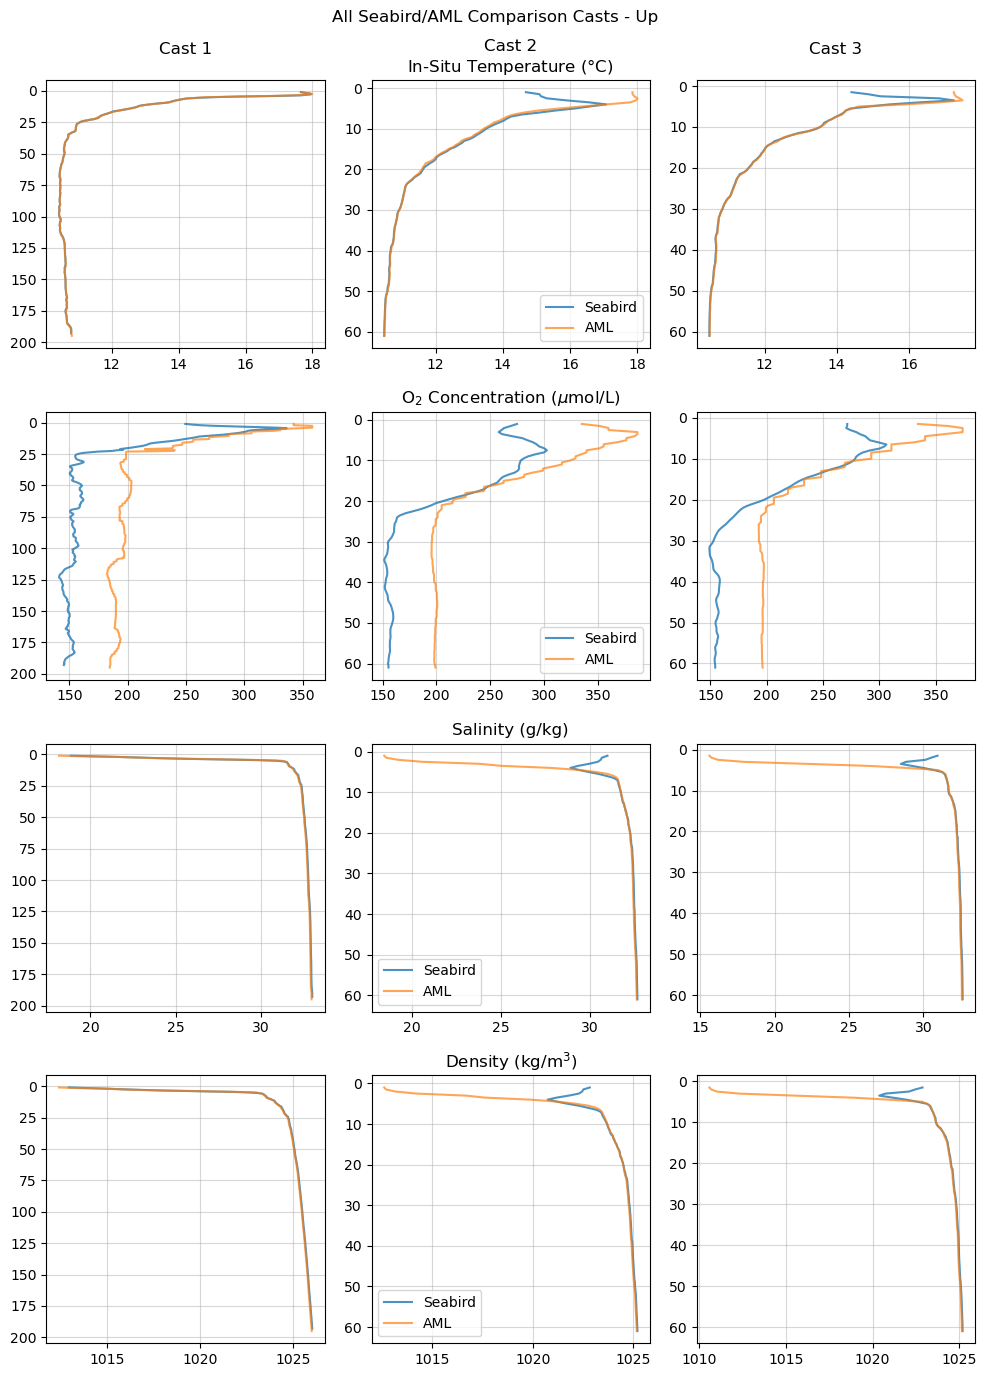

In [57]:
fig, axs = plt.subplots(4, 3, figsize=(10, 14))

# Temp
axs[0, 0].plot(sb_up1_temps_binned, sb_up1_pres_binned, label='Seabird', alpha=0.8)
axs[0, 0].plot(aml_up1_temps_binned, aml_up1_pres_binned, label='AML', alpha=0.7)
axs[0, 0].invert_yaxis()
axs[0, 0].grid(alpha=0.5)
axs[0, 0].set_title("Cast 1\n")

axs[0, 1].plot(sb_up2_temps_binned, sb_up2_pres_binned, label='Seabird', alpha=0.8)
axs[0, 1].plot(aml_up2_temps_binned, aml_up2_pres_binned, label='AML', alpha=0.7)
axs[0, 1].legend(loc=4)
axs[0, 1].invert_yaxis()
axs[0, 1].grid(alpha=0.5)
axs[0, 1].set_title("Cast 2\nIn-Situ Temperature ($\degree$C)")

axs[0, 2].plot(sb_up3_temps_binned, sb_up3_pres_binned, label='Seabird', alpha=0.8)
axs[0, 2].plot(aml_up3_temps_binned, aml_up3_pres_binned, label='AML', alpha=0.7)
axs[0, 2].invert_yaxis()
axs[0, 2].grid(alpha=0.5)
axs[0, 2].set_title("Cast 3\n")

# Oxygen
axs[1, 0].plot(sb_up1_oxys_binned, sb_up1_pres_binned, label='Seabird', alpha=0.8)
axs[1, 0].plot(aml_up1_oxys_binned, aml_up1_pres_binned, label='AML', alpha=0.7)
axs[1, 0].invert_yaxis()
axs[1, 0].grid(alpha=0.5)

axs[1, 1].plot(sb_up2_oxys_binned, sb_up2_pres_binned, label='Seabird', alpha=0.8)
axs[1, 1].plot(aml_up2_oxys_binned, aml_up2_pres_binned, label='AML', alpha=0.7)
axs[1, 1].legend(loc=4)
axs[1, 1].invert_yaxis()
axs[1, 1].grid(alpha=0.5)
axs[1, 1].set_title("O$_2$ Concentration ($\mu$mol/L)")

axs[1, 2].plot(sb_up3_oxys_binned, sb_up3_pres_binned, label='Seabird', alpha=0.8)
axs[1, 2].plot(aml_up3_oxys_binned, aml_up3_pres_binned, label='AML', alpha=0.7)
axs[1, 2].invert_yaxis()
axs[1, 2].grid(alpha=0.5)

# Salinity
axs[2, 0].plot(sb_up1_sals_binned, sb_up1_pres_binned, label='Seabird', alpha=0.8)
axs[2, 0].plot(aml_up1_sals_binned, aml_up1_pres_binned, label='AML', alpha=0.7)
axs[2, 0].invert_yaxis()
axs[2, 0].grid(alpha=0.5)

axs[2, 1].plot(sb_up2_sals_binned, sb_up2_pres_binned, label='Seabird', alpha=0.8)
axs[2, 1].plot(aml_up2_sals_binned, aml_up2_pres_binned, label='AML', alpha=0.7)
axs[2, 1].legend(loc=3)
axs[2, 1].invert_yaxis()
axs[2, 1].grid(alpha=0.5)
axs[2, 1].set_title("Salinity (g/kg)")

axs[2, 2].plot(sb_up3_sals_binned, sb_up3_pres_binned, label='Seabird', alpha=0.8)
axs[2, 2].plot(aml_up3_sals_binned, aml_up3_pres_binned, label='AML', alpha=0.7)
axs[2, 2].invert_yaxis()
axs[2, 2].grid(alpha=0.5)

# Density
axs[3, 0].plot(sb_up1_dens_binned, sb_up1_pres_binned, label='Seabird', alpha=0.8)
axs[3, 0].plot(aml_up1_dens_binned, aml_up1_pres_binned, label='AML', alpha=0.7)
axs[3, 0].invert_yaxis()
axs[3, 0].locator_params(axis='x', nbins=3)
axs[3, 0].grid(alpha=0.5)

axs[3, 1].plot(sb_up2_dens_binned, sb_up2_pres_binned, label='Seabird', alpha=0.8)
axs[3, 1].plot(aml_up2_dens_binned, aml_up2_pres_binned, label='AML', alpha=0.7)
axs[3, 1].legend(loc=3)
axs[3, 1].invert_yaxis()
axs[3, 1].grid(alpha=0.5)
axs[3, 1].locator_params(axis='x', nbins=3)
axs[3, 1].set_title("Density (kg/m$^3$)")

axs[3, 2].plot(sb_up3_dens_binned, sb_up3_pres_binned, label='Seabird', alpha=0.8)
axs[3, 2].plot(aml_up3_dens_binned, aml_up3_pres_binned, label='AML', alpha=0.7)
axs[3, 2].invert_yaxis()
axs[3, 2].grid(alpha=0.5)
# axs[3, 2].locator_params(axis='x', nbins=3)

plt.suptitle("All Seabird/AML Comparison Casts - Up")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

plt.savefig('figs/all_calibs_upcast.png')
plt.show()


#### Oxygen Calibration of AML to Seabird

<i>Method</i>

i. For each profile, plot AML O2 values as function of Seabird values

ii. Fit a linear regression to each

iii. Take the mean gain & bias as the calibration 

In [58]:
print(len(aml_down1_corr_oxys_binned), len(sb_down1_oxys_binned))
print(len(aml_down2_corr_oxys_binned), len(sb_down2_oxys_binned))
print(len(aml_down3_corr_oxys_binned), len(sb_down3_oxys_binned))

392 390
122 120
122 122


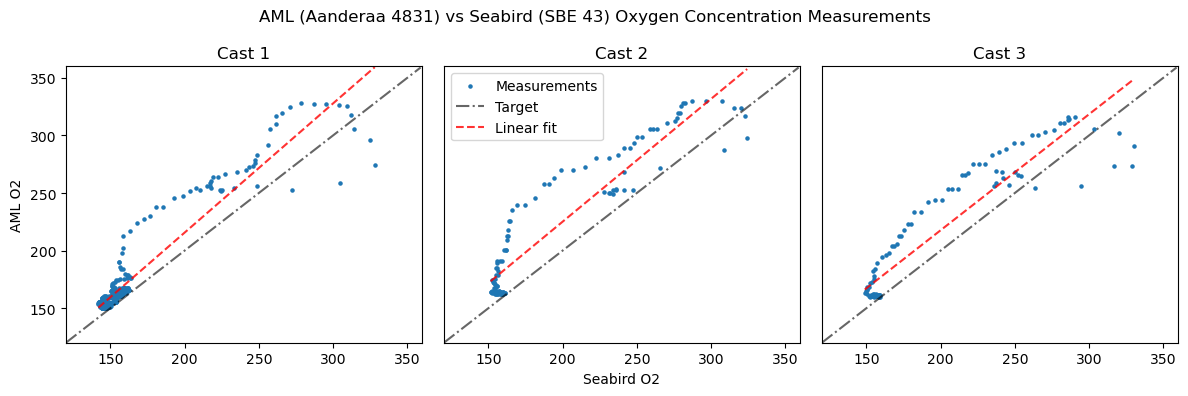

In [59]:
aml1_clipped = aml_down1_corr_oxys_binned[1:-3]
sb1_clipped = sb_down1_oxys_binned[1:-1]

aml2_clipped = aml_down2_corr_oxys_binned[1:-2]
sb2_clipped = sb_down2_oxys_binned[1:]

aml3_clipped = aml_down3_corr_oxys_binned[1:-1]
sb3_clipped = sb_down3_oxys_binned[1:-1]

lr1 = LinearRegression()
lr1.fit(np.array(sb1_clipped).reshape(-1,1), np.array(aml1_clipped).reshape(-1,1))
reg_down1 = lr1.predict(np.sort(np.array(sb1_clipped)).reshape(-1,1))

lr2 = LinearRegression()
lr2.fit(np.array(sb2_clipped).reshape(-1,1), np.array(aml2_clipped).reshape(-1,1))
reg_down2 = lr2.predict(np.sort(np.array(sb2_clipped)).reshape(-1,1))

lr3 = LinearRegression()
lr3.fit(np.array(sb3_clipped).reshape(-1,1), np.array(aml3_clipped).reshape(-1,1))
reg_down3 = lr3.predict(np.sort(np.array(sb3_clipped)).reshape(-1,1))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(sb1_clipped, aml1_clipped, s=5)
axs[0].plot(np.sort(sb1_clipped), reg_down1, 'r--', alpha=0.8)

axs[1].scatter(sb2_clipped, aml2_clipped, s=5, label='Measurements')

for ax in axs:
    ax.set_xlim([120, 360])
    ax.set_ylim([120, 360])
    ax.plot(np.arange(120, 360), np.arange(120, 360), 'k-.', alpha=0.6, label='Target')

axs[1].plot(np.sort(sb2_clipped), reg_down2, 'r--', alpha=0.8, label='Linear fit')

axs[2].scatter(sb3_clipped, aml3_clipped, s=5)
axs[2].plot(np.sort(sb3_clipped), reg_down3, 'r--', alpha=0.8)

axs[1].legend()
axs[0].set_ylabel("AML O2")
axs[1].set_xlabel("Seabird O2")
axs[1].set_yticks([])
axs[2].set_yticks([])

axs[0].set_title("Cast 1")
axs[1].set_title("Cast 2")
axs[2].set_title("Cast 3")

fig.suptitle("AML (Aanderaa 4831) vs Seabird (SBE 43) Oxygen Concentration Measurements")
fig.tight_layout()

# plt.savefig('calib_comparison_plot.png')
plt.show()

In [60]:
M_cal1 = (reg_down1[-1]-reg_down1[0])/(np.sort(aml1_clipped)[-1]-np.sort(aml1_clipped)[0]) # rise/run
B_cal1 = reg_down1[0] - M_cal1*np.sort(aml1_clipped)[0] # y_0 - m_cal*x_0

M_cal2 = (reg_down2[-1]-reg_down2[0])/(np.sort(aml2_clipped)[-1]-np.sort(aml2_clipped)[0])
B_cal2 = reg_down2[0] - M_cal2*np.sort(aml2_clipped)[0]

M_cal3 = (reg_down3[-1]-reg_down3[0])/(np.sort(aml3_clipped)[-1]-np.sort(aml3_clipped)[0])
B_cal3 = reg_down3[0] - M_cal3*np.sort(aml3_clipped)[0]

print(f"Gains: {M_cal1}, {M_cal2}, {M_cal3}")
print(f"Biases: {B_cal1}, {B_cal2}, {B_cal3}")

M_cal_mean = np.mean([M_cal1, M_cal2, M_cal3])
B_cal_mean = np.mean([B_cal1, B_cal2, B_cal3])

print(f"Mean calibration: M={M_cal_mean:.2f}, B={B_cal_mean:.2f}")

def calibrate_o2(data, m, b):
    return (data/m)-b

Gains: [1.17564097], [1.09670221], [1.17001816]
Biases: [-26.17649883], [-4.25767427], [-20.58780733]
Mean calibration: M=1.15, B=-17.01


Apply calibration to downcast data

In [61]:
aml_down1_cal_oxys_binned = [calibrate_o2(d, M_cal_mean, B_cal_mean) for d in aml_down1_corr_oxys_binned]
aml_down2_cal_oxys_binned = [calibrate_o2(d, M_cal_mean, B_cal_mean) for d in aml_down2_corr_oxys_binned]
aml_down3_cal_oxys_binned = [calibrate_o2(d, M_cal_mean, B_cal_mean) for d in aml_down3_corr_oxys_binned]

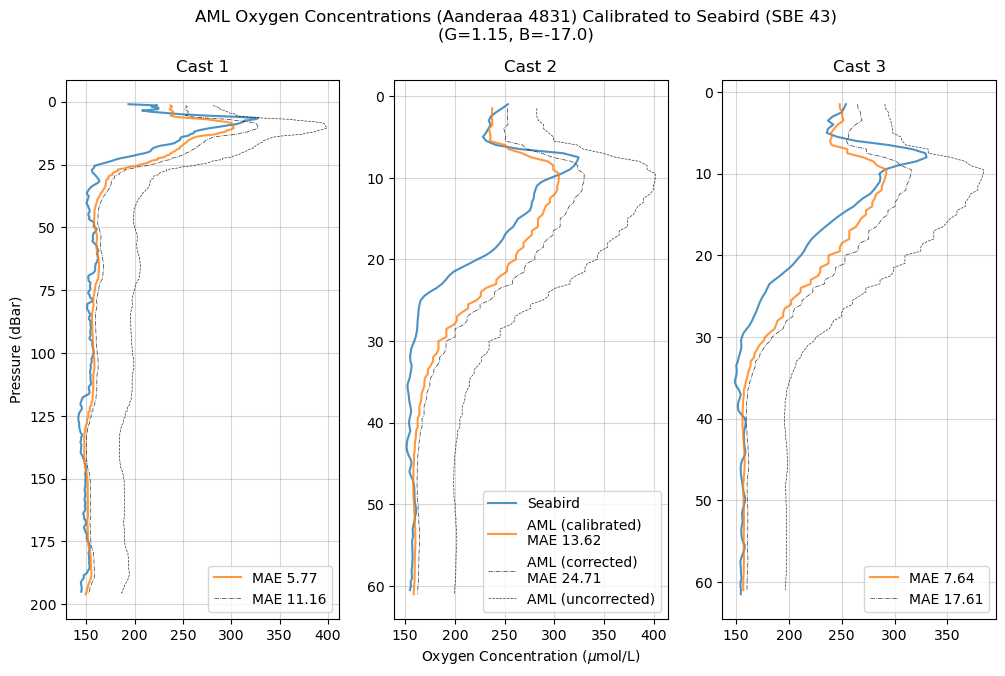

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(12, 7))

MAE_uncal1 = np.mean(np.array(aml_down1_corr_oxys_binned[1:-3]) - np.array(sb1_clipped))
MAE_cal1 = np.mean(np.array(aml_down1_cal_oxys_binned[1:-3]) - np.array(sb1_clipped))

MAE_uncal2 = np.mean(np.array(aml_down2_corr_oxys_binned[1:-2]) - np.array(sb2_clipped))
MAE_cal2 = np.mean(np.array(aml_down2_cal_oxys_binned[1:-2]) - np.array(sb2_clipped))

MAE_uncal3 = np.mean(np.array(aml_down3_corr_oxys_binned[1:-1]) - np.array(sb3_clipped))
MAE_cal3 = np.mean(np.array(aml_down3_cal_oxys_binned[1:-1]) - np.array(sb3_clipped))

axs[0].plot(sb_down1_oxys_binned, sb_down1_pres_binned, alpha=0.8)
axs[0].plot(aml_down1_cal_oxys_binned, aml_down1_pres_binned,  alpha=0.8, label=f"MAE {MAE_cal1:.2f}")
axs[0].plot(aml_down1_corr_oxys_binned, aml_down1_pres_binned, 'k-.', alpha=0.8, linewidth=0.5, label=f"MAE {MAE_uncal1:.2f}")
axs[0].plot(aml_down1_oxys_binned, aml_down1_pres_binned, 'k--', alpha=0.8, linewidth=0.5)
axs[0].invert_yaxis()
axs[0].grid(alpha=0.5)
axs[0].legend()
axs[0].set_title(f"Cast 1")

axs[1].plot(sb_down2_oxys_binned, sb_down2_pres_binned, label='Seabird', alpha=0.8)
axs[1].plot(aml_down2_cal_oxys_binned, aml_down2_pres_binned, label=f'AML (calibrated)\nMAE {MAE_cal2:.2f}', alpha=0.8)
axs[1].plot(aml_down2_corr_oxys_binned, aml_down2_pres_binned, 'k-.', label=f'AML (corrected)\nMAE {MAE_uncal2:.2f}', alpha=0.8, linewidth=0.5)
axs[1].plot(aml_down2_oxys_binned, aml_down2_pres_binned, 'k--', label='AML (uncorrected)', alpha=0.8, linewidth=0.5)
axs[1].legend(loc=4)
axs[1].invert_yaxis()
axs[1].grid(alpha=0.5)
axs[1].set_title("Cast 2")

axs[2].plot(sb_down3_oxys_binned, sb_down3_pres_binned, alpha=0.8)
axs[2].plot(aml_down3_cal_oxys_binned, aml_down3_pres_binned, label=f'MAE {MAE_cal3:.2f}', alpha=0.8)
axs[2].plot(aml_down3_corr_oxys_binned, aml_down3_pres_binned, 'k-.', label=f'MAE {MAE_uncal3:.2f}', alpha=0.8, linewidth=0.5)
axs[2].plot(aml_down3_oxys_binned, aml_down3_pres_binned, 'k--', alpha=0.8, linewidth=0.5)
axs[2].invert_yaxis()
axs[2].grid(alpha=0.5)
axs[2].legend()
axs[2].set_title("Cast 3")

axs[1].set_xlabel("Oxygen Concentration ($\mu$mol/L)")
axs[0].set_ylabel("Pressure (dBar)")

fig.suptitle("AML Oxygen Concentrations (Aanderaa 4831) Calibrated to Seabird (SBE 43)\n(G=1.15, B=-17.0)")

plt.savefig("figs/calib_all_downcasts.png")
plt.show()
